# AST/STAT 5731 Project 3

Group 5: Darya Biparva, Xiaoxiao Kou, John Miller Jr, Sam Penders

## Introduction

Gamma-ray bursts (GRBs) are short duration, highly energetic electromagnetic radiation that are detected from extragalactic sources. The nature of GRBs, i.e. how they are produced, where they are produced, etc., is not currently known. However, there seems to be at least two different classes of GRBs, which was first discovered and published in Meegan et al. 1993 (Figure 1): short events (< 2s) and longer ones (> 2s). The duration of these events are defined to be 'the time during which the cumulative counts increase from 5% to 95% above background, thus encompassing 90% of the total GRB counts,' and is called 'T90'. A similar definintion is applied for the T50 duration (not used here). A bimodal distribution is revealed when plotting a histogram of numerous log(T90) observations (short and long GRBs). Therefore, the distribution of GRB T90s follow a bimodal lognormal distribution. 

*Figure 1 (Below): The T90 distribution found in Meegan et al. 1993.*

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('/content/image.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

AttributeError: ignored

Since 1993, many papers have published GRB T90 observations and their distributions. One of these papers, Ripa et al. 2009, published their T90 distribution and the chi-squared parameters that were fit to the bimodal lognormal distribution. Our main research goal is to determine how the bimodal distribution parameters of GRBs from Ripa et al. 2009 change with new GRB observations, specifically from Bhat et al. 2016. Narrowing the estimated bimodal distributions of these classes will allow for a more robust analysis and determination of the astronomical processes that could be generating these GRBs. 

References:
> [Meegan et al. 1993](https://articles.adsabs.harvard.edu/pdf/1993ApJ...413L.101K)
> 
> [Ripe et al. 2009](https://www.aanda.org/articles/aa/pdf/2009/17/aa10913-08.pdf), ([CDS Link](https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/498/399)\)
>
> [Bhat et al. 2016](https://iopscience.iop.org/article/10.3847/0067-0049/223/2/28/pdf), ([CDS Link](https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJS/223/28)\)




---



## Statistical model

> $N = \mathrm{\#\, Observations} $
> 
> $i \in \{1, 2, \dots, N\}$
>
> $f_Y(y) = w_s f_s(y \,\vert\, \mu_s, \rho_s) + w_l f_l(y \,\vert\, \mu_l, \rho_l) $
> 
> $(w_s, w_l) \sim \mathrm{Dirichlet}_2(p_1, p_2)$
>
> $z_i \,\vert\, w_s, w_l \sim \mathrm{Categorical}(w_s, w_l)$
>
> $\mu_s \sim \mathrm{Normal}(m_s, s_s)$
> 
> $\mu_l \sim \mathrm{Normal}(m_l, s_l)$
> 
> $\sigma_s \sim \mathrm{Gamma}(a_s, b_s)$
>
> $\sigma_l \sim \mathrm{Gamma}(a_l, b_l)$

We parametized the Gamma distributions in terms of their mean $a$ and standard deviation $b$. $f_j(y \,\vert\, \mu_j, \sigma_j)$ is the lognormal density for each component $j \in \{s, l\}$:
>
> $f_j(y \,\vert\, \mu_j, \sigma_j) = \frac{1}{y \sigma_j \sqrt{2 \pi}} \exp{ \Big( {-\frac{(\ln(y) - \mu_j)^2}{2 \sigma_j^2} \Big) } }$.

## Sample space

> $Y_i \in (0, \infty)$
>
> $(w_s, w_l) \in [0, 1]^2 \,\mathrm{s.t.}\, w_s + w_l = 1$
>
> $z_i \in \{s, l\}$
>
> $\mu_s, \mu_l \in \mathbb{R}$
>
> $\sigma_s, \sigma_l \in (0, \infty)$
> 
## Priors

Our priors are based on results from Ripa et. al. Because the reported values of $\mu, \sigma$ and their standard errors are reported for a base-10 lognormal model, we convert these values to base-$e$ by dividing by a factor of $\log_{10}(e)$. We assume that the values of $\mu$ and $\sigma$ reported by Ripa et. al. followed a normal distribution with standard deviations given by the reported errors, so we can simply transform the mean and standard error for these distributions by dividing by $\log_{10}(e)$.

Thus, our priors are:

> $(m_s, s_s) = (-1.06,  0.30)$
> 
> $(m_l, s_l) = (2.90, 0.07)$
> 
> $(a_s, b_s)= (1.38, 0.14)$
> 
> $(a_l, b_l) = (0.97, 0.02)$
>
> $(w_s, w_l) = (0.19, 0.81)$

## Analysis

In [ ]:
import pandas as pd
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import xarray as xr

! pip install watermark
! pip install corner
import corner
import watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 22.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# print library versions used
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Fri Dec 16 2022

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

xarray: 0.20.2

seaborn   : 0.11.2
corner    : 2.2.1
watermark : 2.3.1
numpy     : 1.21.6
arviz     : 0.12.1
matplotlib: 3.2.2
pymc      : 4.1.4
xarray    : 0.20.2
astropy   : 4.3.1
pandas    : 1.3.5

Watermark: 2.3.1



In [ ]:
# importing data from CDS
data = ascii.read("https://cdsarc.cds.unistra.fr/ftp/J/ApJS/223/28/table6.dat", \
                   readme="https://cdsarc.cds.unistra.fr/ftp/J/ApJS/223/28/ReadMe").to_pandas() 

prior_data = ascii.read("https://cdsarc.cds.unistra.fr/ftp/J/A+A/498/399/table7.dat", \
                   readme="https://cdsarc.cds.unistra.fr/ftp/J/A+A/498/399/ReadMe").to_pandas() 

data['logT90'] = np.log(data['T90'])
prior_data['logT90'] = np.log(prior_data['T90'])
data['log10T90'] = np.log10(data['T90'])
prior_data['log10T90'] = np.log10(prior_data['T90'])
y = data['T90']

In [ ]:
data[['T90','e_T90']].describe()

,T90,e_T90
count,1405.000000,1405.000000
mean,39.642738,3.068405
std,62.551492,3.727814
min,0.048000,0.036000
25%,5.760000,0.831000
50%,20.224000,1.863000
75%,48.897000,3.874000
max,828.672000,35.377000


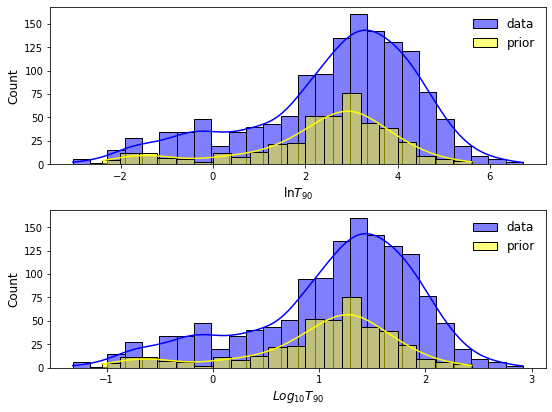

In [ ]:
fig, axs = plt.subplots(2, 1,figsize=(8,6))
fig.tight_layout(pad=2.5)
sns.histplot(data=data, x='logT90', kde=True, ax=axs[0], label='data', color='blue')
sns.histplot(data=prior_data, x='logT90', kde=True, ax=axs[0], label='prior', color='yellow')
axs[0].set_xlabel(r"$\ln T_{90}$",fontsize=12)
axs[0].set_ylabel("Count",fontsize=12)
sns.histplot(data=data, x='log10T90', kde=True, ax=axs[1], label='data', color='blue')
sns.histplot(data=prior_data, x='log10T90', kde=True, ax=axs[1], label='prior', color='yellow')
axs[1].set_xlabel(r"$\log_{10} T_{90}$",fontsize=12)
axs[1].set_ylabel("Count",fontsize=12)
axs[0].legend(frameon=False,fontsize=12)
axs[1].legend(frameon=False,fontsize=12)

 As mentioned previously, we obtained the priors from Ripa et. al. we observe a slight shift in the density. This means that we can potentially get a slightly different result from what was reported in Ripa et. al.
 Also, as mentioned previously, we note that the results reported in Ripa et. al were based on a lognormal distribution that uses $\log_{10}$. However, we're using natural logarithm and we have adjusted the priors accordingly. The figure above depicts the difference. The upper figure is the distribution of $\ln (y)$. We can see that the second mean is located between 2 and 4. However, the second figure illustrates the distribution of $\log_{10}(y)$. The second mean is located between 1 and 2. 

In [ ]:
# Priors
from math import log10, e

# convert to log base e
mu_short = -0.46 / log10(e)
se_mu_short = 0.13 / log10(e)
sigma_short = 0.60 / log10(e)
se_sigma_short = 0.06 / log10(e)
w_short = 0.187
se_w_short = 0.015 / log10(e)

mu_long = 1.26 / log10(e)
se_mu_long = 0.03 / log10(e)
sigma_long = 0.42 / log10(e)
se_sigma_long = 0.01 / log10(e)
w_long = 0.813
se_w_long = 0.015 / log10(e)

n = len(y)

print('mu_s {:.2f} {:.2f}'.format(mu_short, se_mu_short))
print('mu_l {:.2f} {:.2f}'.format(mu_long, se_mu_long))
print('sigma_s {:.2f} {:.2f}'.format(sigma_short, se_sigma_short))
print('sigma_l {:.2f} {:.2f}'.format(sigma_long, se_sigma_long))
print('w_short, long {:.2f} {:.2f}'.format(w_short, w_long))
print('data counts: {:d}'.format(n))

mu_s -1.06 0.30
mu_l 2.90 0.07
sigma_s 1.38 0.14
sigma_l 0.97 0.02
w_short, long 0.19 0.81
data counts: 1405


The transformation $z = \frac{x}{\log_{10}(e)}$ is applied to mean and standard deviations in order to get the priors applicable to our analysis ($z$ is the new prior for our case).

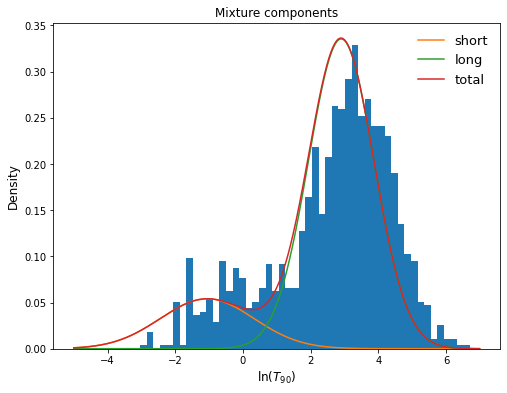

In [ ]:
# plot of data and prior mixture components
from scipy.stats import norm
xx = np.arange(-5, 7, 0.01)
y_short = w_short * norm.pdf(xx, loc=mu_short, scale=sigma_short)
y_long = w_long * norm.pdf(xx, loc=mu_long, scale=sigma_long)
y_total = y_short + y_long

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.log(y), bins=50, density=True)
ax.plot(xx, y_short, label='short')
ax.plot(xx, y_long, label='long')
ax.plot(xx, y_total, label='total')

ax.set_xlabel(r'$\ln(T_{90})$',fontsize=12)
ax.set_ylabel('Density',fontsize=12)
ax.set_title('Prior likelihood and data',fontsize=12)

ax.legend(frameon=False,fontsize=13)

Again, we note that the distribution obtained from the priors is slightly different from the empirical distribution of our data.

### Mixture Model
#### Mixture Model Without Incorporating Measurement Errors

In [ ]:
RANDOM_STATE = 5731

with pm.Model() as model2:
    # mixture weights
    w = pm.Dirichlet('w', a=np.array([w_short, w_long]))


    mu_s = pm.Normal('mu_s', mu=mu_short, sigma=se_mu_short)
    mu_l = pm.Normal('mu_l', mu=mu_long, sigma=se_mu_long)


    sigma_s = pm.Gamma('sigma_s', mu=sigma_short, sigma=se_sigma_short)
    sigma_l = pm.Gamma('sigma_l', mu=sigma_long, sigma=se_sigma_long)

    components = [
        pm.LogNormal.dist(mu=mu_s, sigma=sigma_s),
        pm.LogNormal.dist(mu=mu_l, sigma=sigma_l),
    ]

    y_obs = pm.Mixture('y_obs', w=w, comp_dists=components, observed=y)

    trace = pm.sample(1000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_s,-0.307,0.104,-0.488,-0.097,0.003,0.002,978.0,1184.0,1.0
mu_l,3.259,0.035,3.196,3.328,0.001,0.001,1265.0,1461.0,1.0
w[0],0.201,0.014,0.176,0.229,0.000,0.000,1064.0,1253.0,1.0
w[1],0.799,0.014,0.771,0.824,0.000,0.000,1064.0,1253.0,1.0
sigma_s,1.172,0.066,1.059,1.300,0.002,0.001,1193.0,1122.0,1.0
sigma_l,1.030,0.019,0.993,1.063,0.001,0.000,1293.0,1307.0,1.0


The table above shows our bayesian estimates of the parameters. As expected the means are slightly different from the ones reported in Ripa et. al.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde5c1ca460>,
      dtype=object)

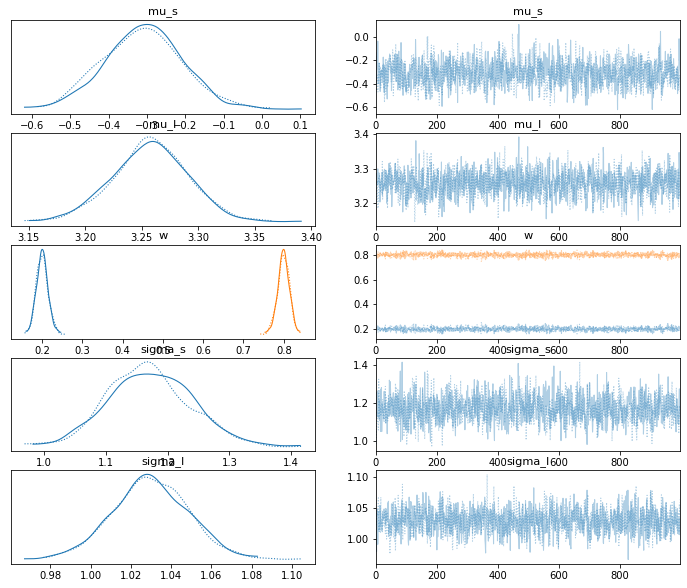

In [ ]:
az.plot_trace(trace)

The figures above depict the results of using NUTS sampler. The figures seem reasonable. We do not observe correlation between samples (Since they look like white noise). In order to further test the credibility of our bayesian analysis, we will conduct the following tests:
> Prior predictive check
>
> ACF plot analysis
>
> Posterior predictive check
>
>Sensitivity analysis

## Prior Predictive Check

In [ ]:
# prior predictive
with model2:
    priortrace = pm.sample_prior_predictive(300, model=model2)

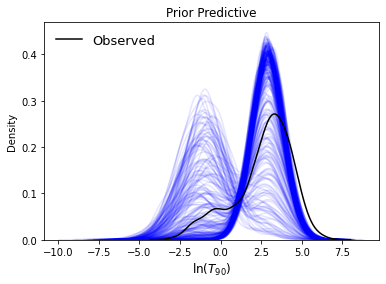

In [ ]:
# prior predictive
for d in priortrace.prior_predictive["y_obs"][0,:,:]:
    d = np.log(d)
    sns.kdeplot(d, color='blue', alpha=0.1)
sns.kdeplot(np.log(y), color='black', label='Observed')
plt.title('Prior Predictive',fontsize=12)
plt.xlabel(r'$\ln (T_{90})$',fontsize=12)
plt.legend(frameon=False,fontsize=13)

Our priors do not lead to a distribution that is at odds with our data. 

# Autocorrelation plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde550f7970>,
      dtype=object)

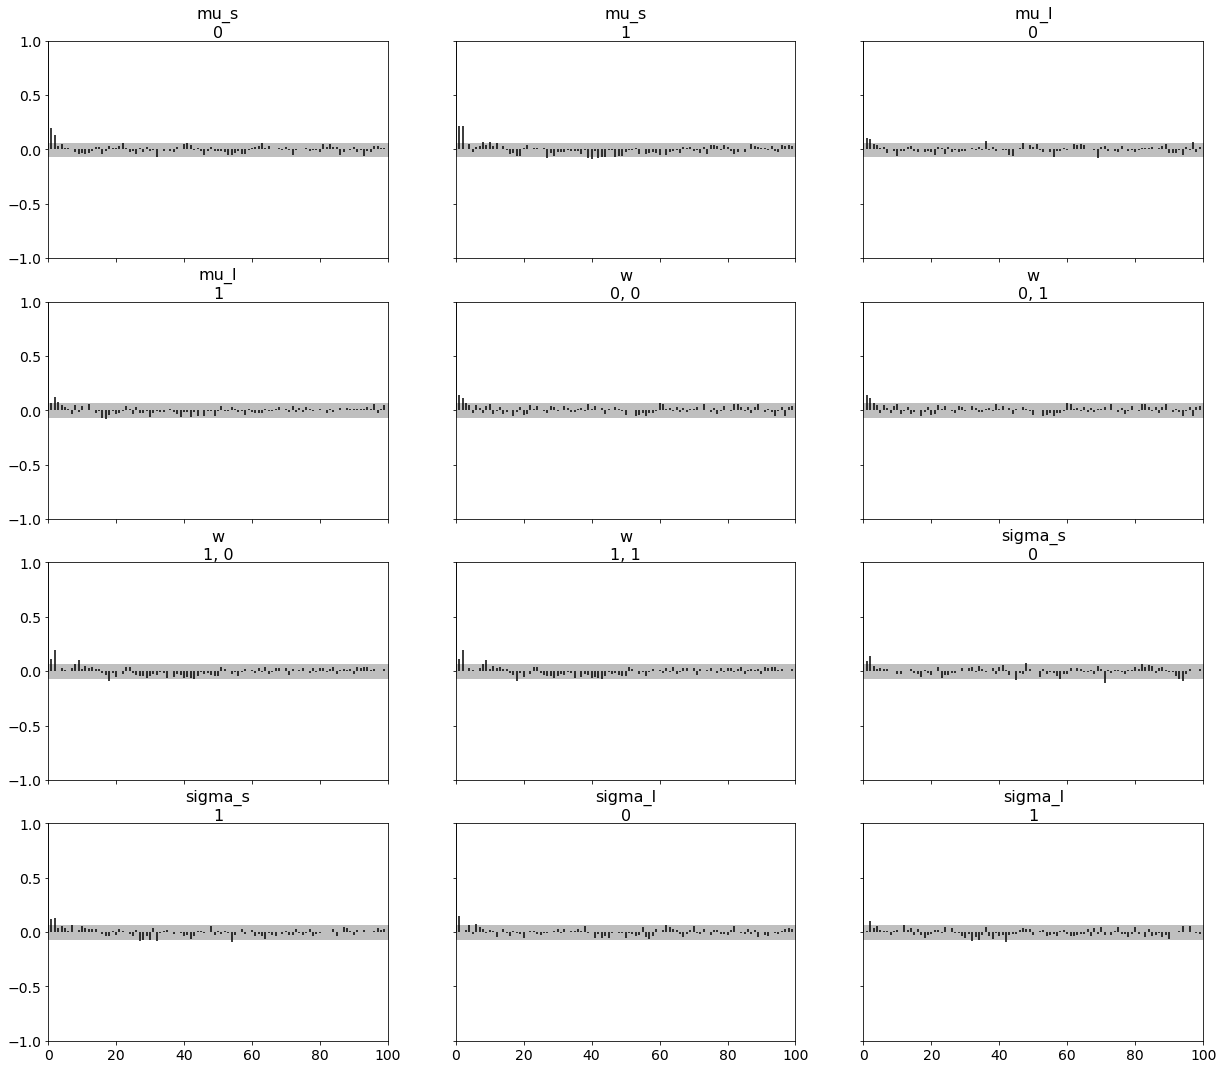

In [ ]:
pm.plot_autocorr(trace)

No significant autocorrelation, thus our samples can be trusted (if our scientific method is sound).

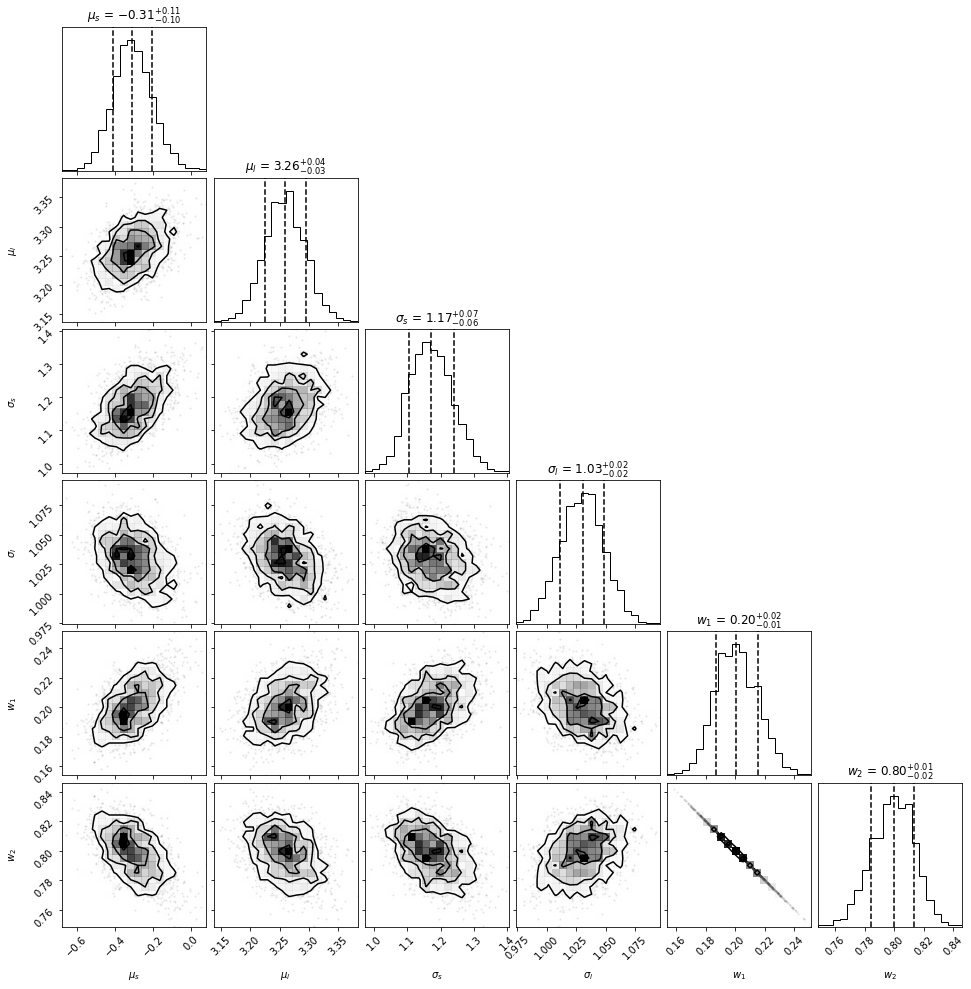

In [ ]:
labels = [r"$\mu_s$",r"$\mu_l$",r"$\sigma_s$",r"$\sigma_l$",r"$w_1$",r'$w_2$']
fig = corner.corner(
    trace, var_names=['mu_s', 'mu_l','sigma_s','sigma_l','w'],labels=labels,quantiles=[0.16, 0.5, 0.84],
    show_titles=True,divergences=True,title_kwargs={"fontsize": 12}
);

# Posterior Predictive Check

In [ ]:
with model2:
    ppc = pm.sample_posterior_predictive(trace=trace)

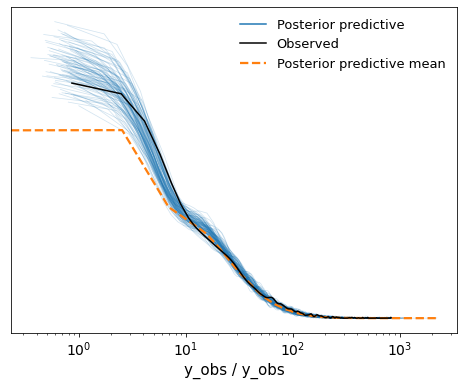

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
az.plot_ppc(ppc,num_pp_samples=100,ax=ax)
ax.legend(frameon=False,fontsize=13)
ax.set_xscale('log')

The posterior predictive agrees closely with our data.

## Sensitivity Analysis

[(-1, 3, 1, 1, 1, 1, 1.5, 1.5, 1, 1), (0.1, 5, 5, 5, 2, 2, 1, 1, 0.2, 0.8), (-3, 2, 1.2, 1.2, 3, 4, 2, 2, 0.8, 0.2)]


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_s    -0.246  0.158  -0.522    0.058      0.006    0.004     647.0   
mu_l     3.331  0.048   3.245    3.424      0.002    0.001     744.0   
w[0]     0.203  0.020   0.169    0.243      0.001    0.001     691.0   
w[1]     0.797  0.020   0.757    0.831      0.001    0.001     691.0   
sigma_s  1.156  0.099   0.987    1.353      0.004    0.003     713.0   
sigma_l  1.080  0.036   1.011    1.147      0.001    0.001     789.0   

         ess_tail  r_hat  
mu_s        791.0   1.01  
mu_l        918.0   1.01  
w[0]        801.0   1.00  
w[1]        801.0   1.00  
sigma_s     809.0   1.00  
sigma_l    1073.0   1.00  


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_s    -0.225  0.173  -0.539    0.090      0.007    0.005     721.0   
mu_l     3.335  0.052   3.238    3.430      0.002    0.001     878.0   
w[0]     0.205  0.021   0.165    0.244      0.001    0.001     788.0   
w[1]     0.795  0.021   0.756    0.835      0.001    0.001     788.0   
sigma_s  1.172  0.110   0.966    1.368      0.004    0.003     799.0   
sigma_l  1.079  0.037   1.006    1.142      0.001    0.001     821.0   

         ess_tail  r_hat  
mu_s        800.0    1.0  
mu_l       1029.0    1.0  
w[0]        945.0    1.0  
w[1]        945.0    1.0  
sigma_s     846.0    1.0  
sigma_l    1127.0    1.0  


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_s    -0.273  0.155  -0.563    0.015      0.007    0.005     523.0   
mu_l     3.325  0.049   3.228    3.410      0.002    0.001     788.0   
w[0]     0.201  0.020   0.164    0.237      0.001    0.001     628.0   
w[1]     0.799  0.020   0.763    0.836      0.001    0.001     628.0   
sigma_s  1.150  0.098   0.964    1.334      0.004    0.003     689.0   
sigma_l  1.087  0.036   1.021    1.152      0.001    0.001     696.0   

         ess_tail  r_hat  
mu_s        914.0   1.00  
mu_l       1117.0   1.00  
w[0]        903.0   1.01  
w[1]        903.0   1.01  
sigma_s     936.0   1.00  
sigma_l    1031.0   1.00  


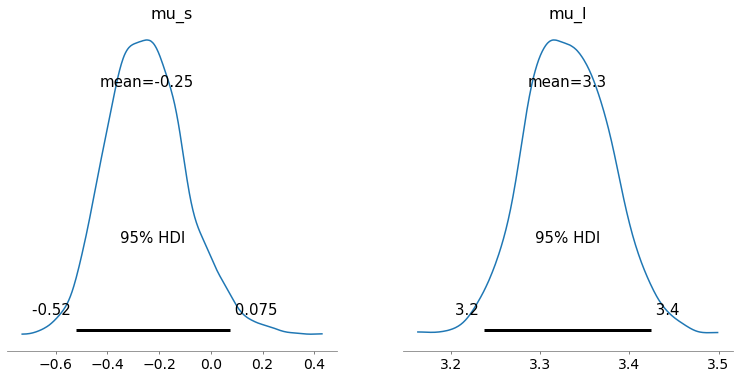

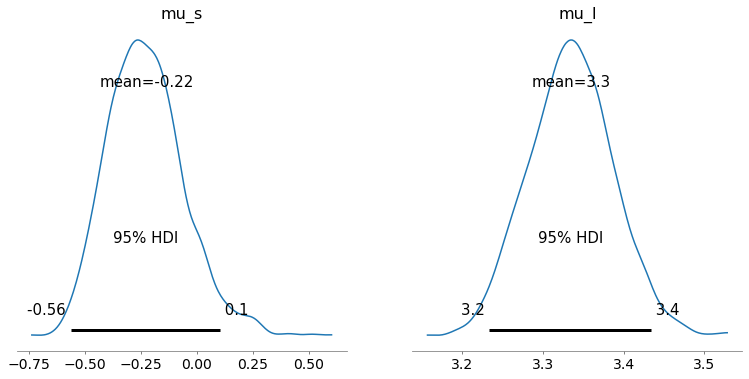

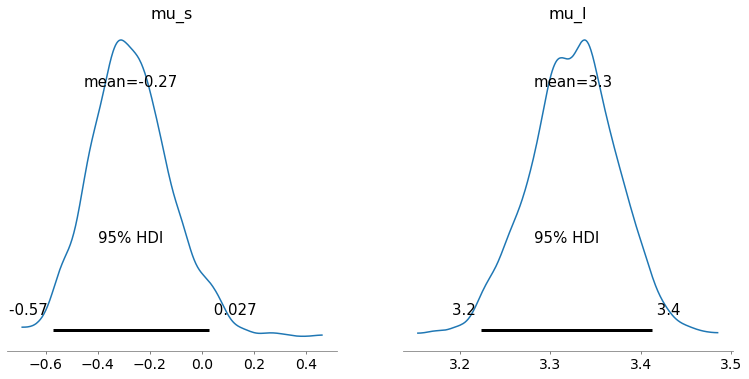

In [ ]:
k=2
y_data = y
mus_short = [-1, 0.1, -3]
mus_long = [3, 5, 2]
ses_mu_short = [1, 5, 1.2]
ses_mu_long = [1, 5, 1.2]
sigmas_short = [1, 2, 3]
sigmas_long = [1, 2, 4]
ses_sigma_short = [1.5, 1, 2]
ses_sigma_long = [1.5, 1, 2]
ws_short = [1, 0.2, 0.8]
ws_long = [1, 0.8, 0.2]
params = list(zip(mus_short, mus_long, ses_mu_short, ses_mu_long, sigmas_short, sigmas_long, ses_sigma_short, ses_sigma_long,
                  ws_short, ws_long))
print(params)
for param in params:
  mu_short = param[0]
  mu_long = param[1]
  se_mu_short = param[2]
  se_mu_long = param[3]
  sigma_short = param[4]
  sigma_long = param[5]
  se_sigma_short = param[6]
  se_sigma_long = param[7]
  w_short = param[8]
  w_long = param[9]
  with pm.Model() as model2:
      # mixture weights
      
      w = pm.Dirichlet('w', a=np.array([w_short, w_long]))


      mu_s = pm.Normal('mu_s', mu=mu_short, sigma=se_mu_short)
      mu_l = pm.Normal('mu_l', mu=mu_long, sigma=se_mu_long)


      sigma_s = pm.Gamma('sigma_s', mu=sigma_short, sigma=se_sigma_short)
      sigma_l = pm.Gamma('sigma_l', mu=sigma_long, sigma=se_sigma_long)

      components = [
          pm.LogNormal.dist(mu=mu_s, sigma=sigma_s),
          pm.LogNormal.dist(mu=mu_l, sigma=sigma_l),
      ]

      y_obs = pm.Mixture('y_obs', w=w, comp_dists=components, observed=y)

      trace = pm.sample(1000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)
      print(az.summary(trace))
      az.plot_posterior(trace.posterior[["mu_s", "mu_l"]],figsize=(13, 6), hdi_prob=0.95)

The results above show that our posterior estimates do not vary largely with sensible priors. However, we note that the second mean does not fall into the 95% interval of our estimate.

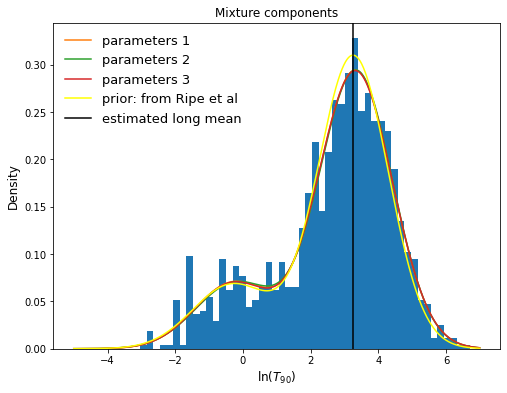

In [ ]:
# plot of data and results from sensitivity analysis
from scipy.stats import norm
xx = np.arange(-5, 7, 0.01)
y_short = 0.201 * norm.pdf(xx, loc=-0.267, scale=1.146)
y_long = 0.799 * norm.pdf(xx, loc=3.323, scale=1.084)
y_total = y_short + y_long



y_short2 = 0.206 * norm.pdf(xx, loc=-0.214, scale=1.180)
y_long2 = 0.794 * norm.pdf(xx, loc=3.338, scale=1.078)
y_total2 = y_short2 + y_long2


y_short3 = 0.199 * norm.pdf(xx, loc=-0.284, scale=1.144)
y_long3 = 0.801 * norm.pdf(xx, loc=3.32, scale=1.089)
y_total3 = y_short3 + y_long3


y_short4 = 0.2 * norm.pdf(xx, loc=-0.311, scale=1.171)
y_long4 = 0.800 * norm.pdf(xx, loc=3.258, scale=1.031)
y_total4 = y_short4 + y_long4


fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.log(y), bins=50, density=True)
ax.plot(xx, y_total, label='parameters 1')
ax.plot(xx, y_total2, label='parameters 2')
ax.plot(xx, y_total3, label='parameters 3')
ax.plot(xx, y_total4, label='prior: from Ripe et al', color = "yellow")
ax.axvline(x=3.258 ,color='k', label="estimated long mean" )
ax.set_xlabel(r'$\ln(T_{90})$',fontsize=12)
ax.set_ylabel('Density',fontsize=12)
ax.set_title('Mixture components',fontsize=12)

ax.legend(frameon=False,fontsize=13)
plt.show()

As the figure illustrates, sensitivity analysis shows that the final estimates are not very sensisitve to the choice of priors. We took our priors from Ripe et al. As mentioned previously, their data and results seem to slightly differ from ours. And this is reflected in our bayesian analysis. 

#### Mixture Model With Measurement Errors

In [ ]:
# prior value for parameters from Ripa et. al with base-10
mu_short_ripa = -0.46 
se_mu_short_ripa = 0.13
sigma_short_ripa = 0.60
se_sigma_short_ripa = 0.06

mu_long_ripa = 1.26
se_mu_long_ripa = 0.03
sigma_long_ripa = 0.42
se_sigma_long_ripa = 0.01

T90 = data['T90']
e_T90 = data['e_T90']

with pm.Model() as model_error:
    # mixture weights
    w = pm.Dirichlet('w', a=np.array([w_short, w_long]))

    mu_s = pm.Normal('mu_s', mu=mu_short_ripa, sigma=se_mu_short_ripa)
    mu_l = pm.Normal('mu_l', mu=mu_long_ripa, sigma=se_mu_long_ripa)

    sigma_s = pm.Gamma('sigma_s', mu=sigma_short_ripa, sigma=se_sigma_short_ripa)
    sigma_l = pm.Gamma('sigma_l', mu=sigma_long_ripa, sigma=se_sigma_long_ripa)

    components = [
        pm.Normal.dist(mu=mu_s, sigma=sigma_s),
        pm.Normal.dist(mu=mu_l, sigma=sigma_l),
    ]
    Y_fit = pm.Mixture('Y_fit', w=w, comp_dists=components,shape=T90.shape)
    Y_obs = pm.Normal('Y_obs',mu=pm.math.exp(np.log(10)*Y_fit),sigma=np.abs(e_T90),observed=T90)
    trace = pm.sample(2000, return_inferencedata=True)

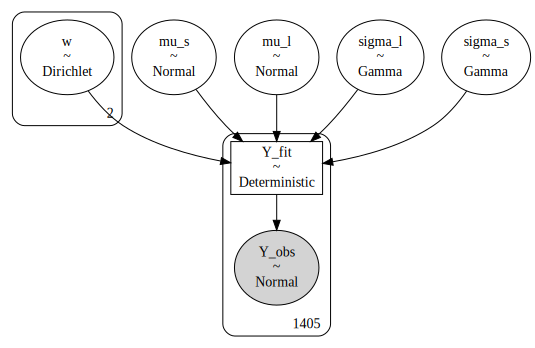

In [ ]:
pm.model_to_graphviz(model_error)

In [ ]:
az.summary(trace,var_names=["mu_s", "mu_l", "sigma_s", "sigma_l", "w"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_s,-0.289,0.055,-0.393,-0.185,0.001,0.001,2269.0,2973.0,1.0
mu_l,1.411,0.015,1.383,1.439,0.000,0.000,4477.0,3290.0,1.0
sigma_s,0.507,0.041,0.429,0.583,0.001,0.001,1637.0,2759.0,1.0
sigma_l,0.447,0.008,0.433,0.462,0.000,0.000,5279.0,3117.0,1.0
w[0],0.207,0.014,0.180,0.234,0.000,0.000,3660.0,2722.0,1.0
w[1],0.793,0.014,0.766,0.820,0.000,0.000,3660.0,2722.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19b15b6a00>,
      dtype=object)

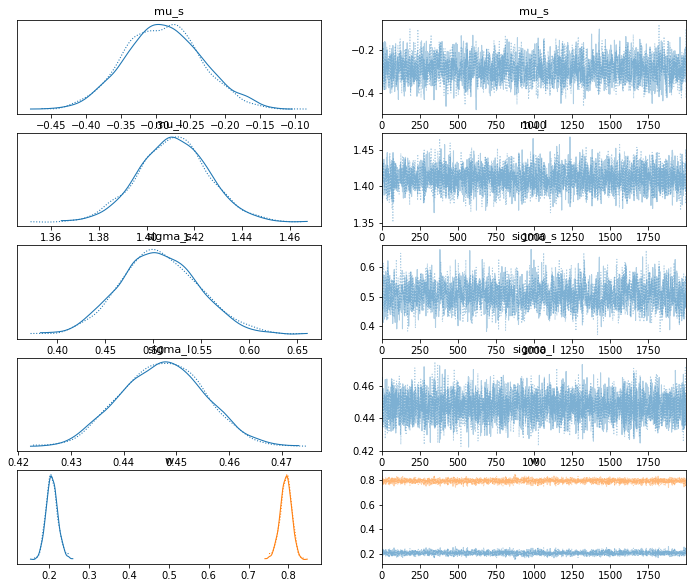

In [ ]:
az.plot_trace(trace,var_names=["mu_s", "mu_l", "sigma_s", "sigma_l", "w"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f199ead5220>,
      dtype=object)

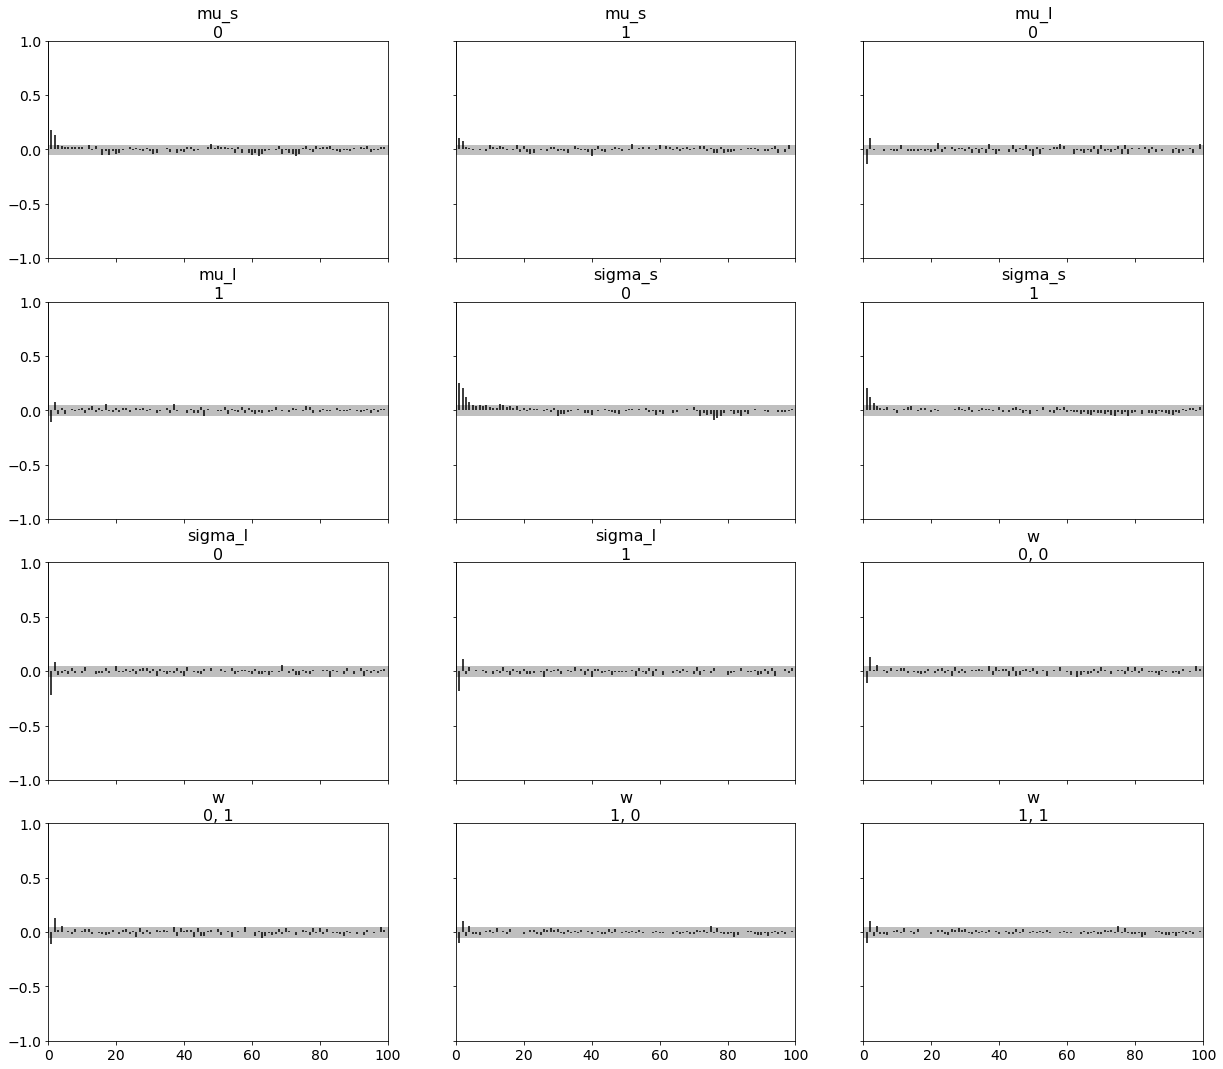

In [ ]:
az.plot_autocorr(trace,var_names=["mu_s", "mu_l", "sigma_s", "sigma_l", "w"])

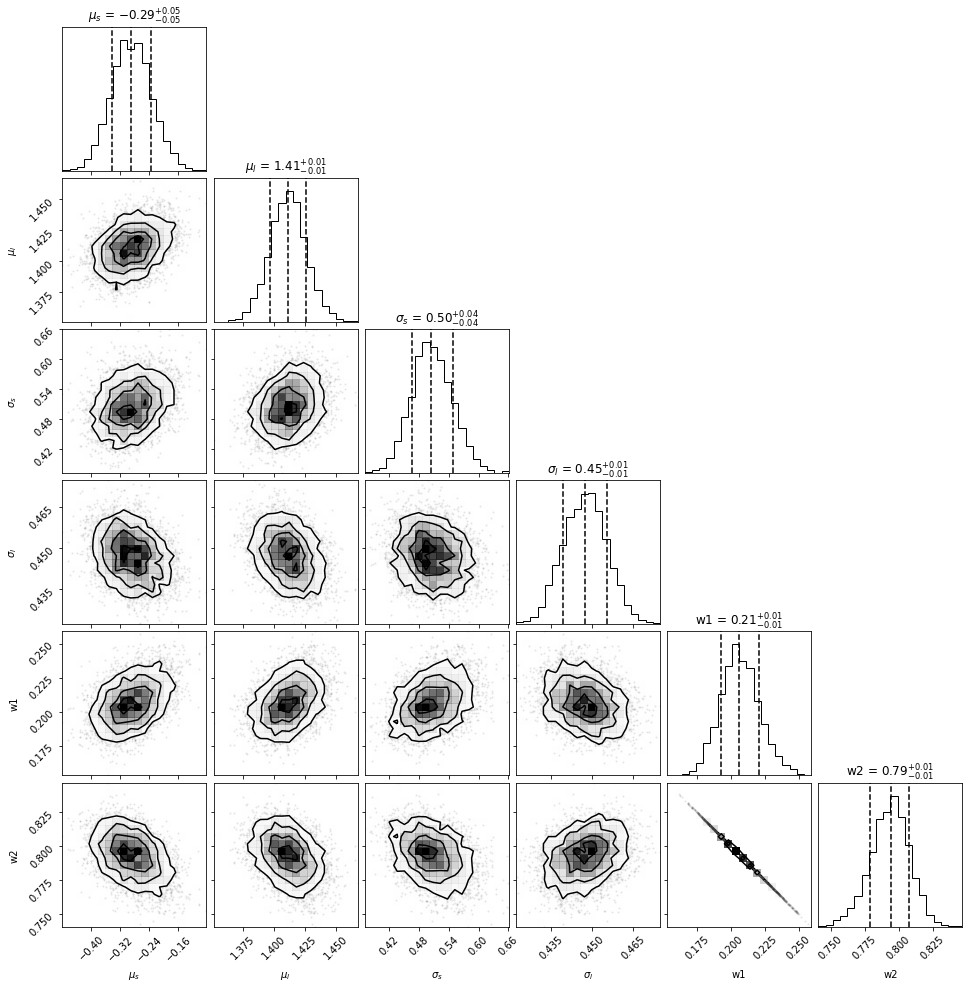

In [ ]:
labels = [r"$\mu_s$",r"$\mu_l$",r"$\sigma_s$",r"$\sigma_l$","w1",'w2']
fig = corner.corner(
    trace, var_names=['mu_s', 'mu_l','sigma_s','sigma_l','w'],labels=labels,quantiles=[0.16, 0.5, 0.84],
    show_titles=True,divergences=True,title_kwargs={"fontsize": 12}
);

-------------------------------------------------------------------------
Mixture Model With Measurement Error From Base-10
mu_s -0.29 0.06
mu_l 1.41 0.01
sigma_s 0.51 0.04
sigma_l 0.45 0.01
w_short, long 0.19 0.81


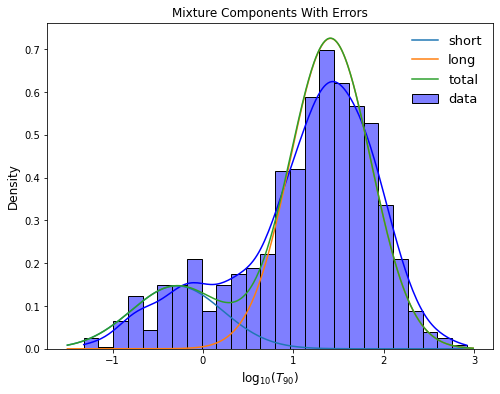

In [ ]:
# plot of data and prior mixture components
from scipy.stats import norm
xx = np.arange(-1.5, 3, 0.01)
w_s, w_l = 0.207, 0.793
mu_s, mu_l = -0.289, 1.411
se_mu_s, se_mu_l = 0.055, 0.015
se_sigma_s, se_sigma_l = 0.041, 0.008
sigma_s, sigma_l = 0.507, 0.447
y_short = w_short * norm.pdf(xx, loc=mu_s, scale=sigma_s)
y_long = w_long * norm.pdf(xx, loc=mu_l, scale=sigma_l)
y_total = y_short + y_long

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=data, x='log10T90', kde=True, ax=ax, label='data', color='blue',stat='density')
ax.plot(xx, y_short, label='short')
ax.plot(xx, y_long, label='long')
ax.plot(xx, y_total, label='total')

ax.set_xlabel(r'$\log_{10}(T_{90})$',fontsize=12)
ax.set_ylabel('Density',fontsize=12)
ax.set_title('Mixture Components With Errors', fontsize=12)

ax.legend(frameon=False,fontsize=13)

print("-------------------------------------------------------------------------")
print("Mixture Model With Measurement Error From Base-10")
print('mu_s {:.2f} {:.2f}'.format(mu_s, se_mu_s))
print('mu_l {:.2f} {:.2f}'.format(mu_l, se_mu_l))
print('sigma_s {:.2f} {:.2f}'.format(sigma_s, se_sigma_s))
print('sigma_l {:.2f} {:.2f}'.format(sigma_l, se_sigma_l))
print('w_short, long {:.2f} {:.2f}'.format(w_short, w_long))

# Conclussion

We performed a Bayesian analysis on the bimodal, lognormal distribution of Gamma Ray Burst (GRB) T90 durations. Our priors were taken from Ripa et a. 2009 and our 'observation' data was taken from Bhat et al. 2016. 

Our mixture model had three main parameters for both peaks: w (Dirichlet), mu (Normal), and sigma (Gamma). The prior information from Ripa et al. 2009 had to be converted from base-10 to base-e, and were:

> $(m_s, s_s) = (-1.06,  0.30)$
> 
> $(m_l, s_l) = (-2.90, 0.07)$
> 
> $(a_s, b_s)= (1.38, 0.14)$
> 
> $(a_l, b_l) = (0.97, 0.02)$
>
> $(w_s, w_l) = (0.19, 0.81)$

We note that the distribution obtained from the priors is slightly different from the empirical distribution. 
